# EMNIST digit classification

## Results of this model on MNIST test data: 
1. 0.22% test error rate with ensemble of 10 CNNs
2. 0.21% test error rate with ensemble of 6 selected CNNs
3. 0.26% test error rate for best single model (model was trained for a few more epochs)

## Test error rates of this model on EMNIST test data:
Model was trained from scratch on EMNIST Digits training data using realtime data augmentation. All test error rates in percent.
1. 0.2499997615814209 test error rate with ensemble of 10 CNNs after 128 epochs
2. 0.1999974250793457 test error rate with ensemble of 10 CNNs after 144 epochs
3. 0.18749833106994629 test error rate with ensemble of 10 CNNs after 160 epochs
4. 0.17499923706054688 test error rate with ensemble of 10 CNNs after 192 epochs
5. 0.17750263214111328 test error rate with ensemble of 10 CNNs after 208 epochs
6. 0.1699984073638916 test error rate with ensemble of 10 CNNs after 240 epochs
6. 0.209999084473 test error rate for best single model after 240 epochs

In [3]:
%matplotlib inline

In [4]:
import keras
import numpy as np
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import Flatten, Lambda, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam as Adam

# try leaky relu
from keras.layers.advanced_activations import LeakyReLU

TODO: Use device=gpu in .theanorc in the next release to make use of the gpuarray backend. For now, this would break the history plotting part of this notebook.

In [5]:
# used to save and load training histories
import pickle
from collections import defaultdict

import resource, sys

# we would reach recursion limit when saving training history otherwise
resource.setrlimit(resource.RLIMIT_STACK, (2**29,-1))
sys.setrecursionlimit(2**29 - 1)

# Load EMNIST Digits dataset
Introduced by https://arxiv.org/abs/1702.05373v1 downloaded from https://www.nist.gov/itl/iad/image-group/emnist-dataset (Matlab format dataset). The matlab format dataset can be conveniently imported with scipy.io.loadmat.

In [8]:
from scipy import io as spio

In [9]:
emnist = spio.loadmat("datasets/matlab/emnist-digits.mat")

In [10]:
# load training dataset
x_train = emnist["dataset"][0][0][0][0][0][0]
x_train = x_train.astype(np.float32)

# load training labels
y_train = emnist["dataset"][0][0][0][0][0][1]

In [11]:
# load test dataset
x_test = emnist["dataset"][0][0][1][0][0][0]
x_test = x_test.astype(np.float32)

# load test labels
y_test = emnist["dataset"][0][0][1][0][0][1]

In [12]:
# store labels for visualization
train_labels = y_train
test_labels = y_test

In [13]:
x_train.shape

(240000, 784)

In [14]:
y_train.shape

(240000, 1)

In [15]:
# normalize
x_train /= 255
x_test /= 255

In [16]:
x_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [17]:
# reshape using matlab order
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28, order="A")
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28, order="A")

In [18]:
x_train.shape

(240000, 1, 28, 28)

In [19]:
y_train.shape

(240000, 1)

In [20]:
# labels should be onehot encoded
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

y_train.shape

(240000, 10)

## Verify we have imported the data correctly

In [21]:
# which sample to look at
samplenum = 5437

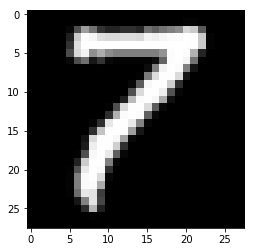

In [22]:
import matplotlib.pyplot as plt

img = x_train[samplenum]

# visualize image
plt.imshow(img[0], cmap='gray')

In [23]:
# show label for sample image
train_labels[samplenum][0]

7

## Reshape test labels

In [24]:
test_labels = test_labels.reshape(40000)

In [25]:
test_labels.shape

(40000,)

# Define model

In [26]:
# calculate mean and standard deviation
mean_px = x_train.mean().astype(np.float32)
std_px = x_train.std().astype(np.float32)

In [27]:
# function to normalize input data
def norm_input(x): return (x-mean_px)/std_px

In [28]:
# Batchnorm + dropout + data augmentation
def create_model():
    model = Sequential([
        Lambda(norm_input, input_shape=(1,28,28), output_shape=(1,28,28)),
        Conv2D(32, (3,3)),
        LeakyReLU(),
        BatchNormalization(axis=1),
        Conv2D(32, (3,3)),
        LeakyReLU(),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Conv2D(64, (3,3)),
        LeakyReLU(),
        BatchNormalization(axis=1),
        Conv2D(64, (3,3)),
        LeakyReLU(),
        MaxPooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512),
        LeakyReLU(),
        BatchNormalization(),
        Dropout(0.3),
        Dense(10, activation='softmax')
    ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Data augmentation
Use keras's data augmentation.

In [29]:
batch_size = 512

In [30]:
from keras.preprocessing.image import ImageDataGenerator

In [31]:
gen = ImageDataGenerator(rotation_range=12, width_shift_range=0.1, shear_range=0.3,
                        height_shift_range=0.1, zoom_range=0.1, data_format='channels_first')
batches = gen.flow(x_train, y_train, batch_size=batch_size)
test_batches = gen.flow(x_test, y_test, batch_size=batch_size)
steps_per_epoch = int(np.ceil(batches.n/batch_size))
validation_steps = int(np.ceil(test_batches.n/batch_size))

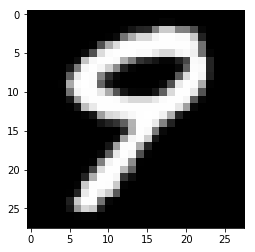

In [32]:
import matplotlib.pyplot as plt

# load ONE image from training set to display on screen
img = x_train[1]

# visualize original image
plt.imshow(img[0], cmap='gray')

In [33]:
# trick our generator into believing img has enough dimensions
# and get some augmented images for our single test image
img = np.expand_dims(img, axis=0)
aug_iter = gen.flow(img)

In [34]:
aug_img = next(aug_iter)[0].astype(np.float32)
aug_img.shape

(1, 28, 28)

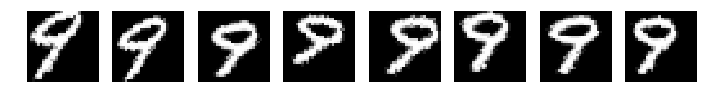

In [35]:
import matplotlib.pyplot as plt

# show augmented images
f = plt.figure(figsize=(12,6))
for i in range(8):
    sp = f.add_subplot(2, 26//3, i+1)
    sp.axis('Off')
    aug_img = next(aug_iter)[0].astype(np.float32)
    plt.imshow(aug_img[0], cmap='gray')

# Ensembling
Here we create ten models and fit them to our augmented data. We use the mean prediction from all ten classifiers as our final prediction. This should average out errors in our classifiers and enable us to predict with higher accuracy.

## Create models using saved weights

In [36]:
models = []

for i in range(10):
    m = create_model()
    m.load_weights('weights/240epochs_weights_model_'+str(i)+'.pkl')
    models.append(m)

## Or create and train ten models from scratch

In [ ]:
models = []
histories = []

# create and train ten models from scratch
for i in range(10):
    m = create_model()
    h = m.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=32, verbose=0,
                        validation_data=test_batches, validation_steps=validation_steps)
    # save model weights
    m.save_weights("weights/Xepochs_weights_model_{}.pkl".format(str(i)))
    # save corresponding training history
    f = open("history/Xepochs_history_model_{}.pkl".format(str(i)),"wb")
    pickle.dump(h, f)
    f.close()
    
    models.append(m)
    histories.append(h)

## Train existing models for a few more epochs
Train models for additional 16 epochs and save model weights as well as corresponding training history.

In [33]:
for i,m in enumerate(models):
    h = m.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=16, verbose=0,
                        validation_data=test_batches, validation_steps=validation_steps)
    # save model weights
    m.save_weights("weights/256epochs_weights_model_{}.pkl".format(str(i)))
    # save corresponding training history
    f = open("history/256epochs_history_model_{}.pkl".format(str(i)),"wb")
    pickle.dump(h, f)
    f.close()

# Evaluate Ensemble of 10 CNNs

In [34]:
eval_batch_size = 512

In [35]:
all_preds = np.stack([m.predict(x_test, batch_size=eval_batch_size) for m in models])

In [36]:
avg_preds = all_preds.mean(axis=0)

In [37]:
# display error rate in percent
(1 - keras.metrics.categorical_accuracy(y_test, avg_preds).eval().mean()) * 100

0.1699984073638916

## Show test error rate of every model separately
All test error rates in percent.

32 epochs: 0.34999847412109375 on ensemble of 10 models
1. 0.470000505447
2. 0.480002164841
3. 0.569999217987
4. 0.599998235703
5. 0.660002231598
6. 0.550001859665
7. 0.429999828339
8. 0.529998540878
9. 0.400000810623
10. 0.379997491837

48 epochs: 0.3099977970123291 on ensemble of 10 models
1. 0.470000505447
2. 0.480002164841
3. 0.38999915123
4. 0.559997558594
5. 0.510001182556
6. 0.520002841949
7. 0.379997491837
8. 0.419998168945
9. 0.520002841949
10. 0.440001487732

64 epochs: 0.29000043869018555 on ensemble of 10 models (learning rate 0.0001)
1. 0.419998168945
2. 0.540000200272
3. 0.480002164841
4. 0.340002775192
5. 0.38999915123
6. 0.58000087738
7. 0.419998168945
8. 0.360000133514
9. 0.520002841949
10. 0.449997186661

80 epochs: 0.26000142097473145 on ensemble of 10 models (learning rate 0.0001)
1. 0.48999786377
2. 0.319999456406
3. 0.419998168945
4. 0.520002841949
5. 0.349998474121
6. 0.400000810623
7. 0.340002775192
8. 0.529998540878
9. 0.429999828339
10. 0.550001859665

96 epochs: 0.26000142097473145 on ensemble of 10 models (learning rate 0.0001)
1. 0.440001487732
2. 0.349998474121
3. 0.419998168945
4. 0.529998540878
5. 0.440001487732
6. 0.429999828339
7. 0.379997491837
8. 0.300002098083
9. 0.449997186661
10. 0.609999895096

112 epochs: 0.26000142097473145 on ensemble of 10 models (learning rate 0.0001)
1. 0.38999915123
2. 0.540000200272
3. 0.400000810623
4. 0.38999915123
5. 0.540000200272
6. 0.480002164841
7. 0.480002164841
8. 0.499999523163
9. 0.419998168945
10. 0.400000810623

128 epochs: 0.2499997615814209 on ensemble of 10 models
1. 0.48999786377
2. 0.38999915123
3. 0.480002164841
4. 0.419998168945
5. 0.419998168945
6. 0.330001115799
7. 0.319999456406
8. 0.440001487732
9. 0.379997491837
10. 0.370001792908

144 epochs: 0.1999974250793457 on ensemble of 10 models
1. 0.2749979496
2. 0.282502174377
3. 0.2749979496
4. 0.309997797012
5. 0.292497873306
6. 0.2749979496
7. 0.244998931885
8. 0.255000591278
9. 0.295001268387
10. 0.267499685287

160 epochs: 0.18749833106994629 on ensemble of 10 models
1. 0.220000743866
2. 0.265002250671
3. 0.265002250671
4. 0.247502326965
5. 0.262498855591
6. 0.257498025894
7. 0.295001268387
8. 0.227499008179
9. 0.242501497269
10. 0.295001268387

176 epochs: 0.18749833106994629 on ensemble of 10 models
1. 0.239998102188
2. 0.249999761581
3. 0.239998102188
4. 0.269997119904
5. 0.262498855591
6. 0.269997119904
7. 0.269997119904
8. 0.227499008179
9. 0.252497196198
10. 0.284999608994

192 epochs: 0.17499923706054688 on ensemble of 10 models
1. 0.244998931885
2. 0.249999761581
3. 0.269997119904
4. 0.239998102188
5. 0.257498025894
6. 0.247502326965
7. 0.227499008179
8. 0.225001573563
9. 0.230002403259
10. 0.232499837875

208 epochs: 0.17750263214111328 on ensemble of 10 models
1. 0.239998102188
2. 0.2749979496
3. 0.249999761581
4. 0.237500667572
5. 0.217497348785
6. 0.29000043869
7. 0.232499837875
8. 0.262498855591
9. 0.272500514984
10. 0.252497196198

224 epochs: 0.18749833106994629 on ensemble of 10 models
1. 0.252497196198
2. 0.234997272491
3. 0.244998931885
4. 0.244998931885
5. 0.244998931885
6. 0.237500667572
7. 0.257498025894
8. 0.227499008179
9. 0.277501344681
10. 0.247502326965

240 epochs: 0.1699984073638916 on ensemble of 10 models
1. 0.234997272491
2. 0.222498178482
3. 0.232499837875
4. 0.249999761581
5. 0.249999761581
6. 0.292497873306
7. 0.234997272491
8. 0.257498025894
9. 0.244998931885
10. 0.209999084473

In [38]:
for i, m in enumerate(models):
    pred = np.array(m.predict(x_test, batch_size=eval_batch_size))
    print(i+1, (1 - keras.metrics.categorical_accuracy(y_test, pred).eval().mean()) * 100)

1 0.234997272491
2 0.222498178482
3 0.232499837875
4 0.249999761581
5 0.249999761581
6 0.292497873306
7 0.234997272491
8 0.257498025894
9 0.244998931885
10 0.209999084473


# Plot Training History

Load and plot saved training histories. Utility functions from https://github.com/fchollet/keras/issues/103

In [11]:
# which model to plot training history of
i = 9

In [12]:
# merge training histories
def merge_dict(dict_list):
    dd = defaultdict(list)    
    for d in dict_list:
        for key, value in d.items():
            if not hasattr(value, '__iter__'):
                value = (value,)       
            [dd[key].append(v) for v in value]
    return dict(dd)

# load pickled data
def load(name):
    filename = open(name,"rb")
    obj = pickle.load(filename)
    filename.close()    
    return(obj)

In [13]:
import glob
histories = glob.glob("history/*model_{}*".format(i))

In [14]:
histories = sorted(histories)

In [18]:
# first history would include zero accuracy and mess up our plot
h0 = load(histories[1])

/home/js/anaconda3/lib/python3.6/site-packages/theano/sandbox/cuda/type.py:597: UserWarning: config.experimental.unpickle_gpu_on_cpu is set to True. Unpickling CudaNdarray as numpy.ndarray
  warnings.warn("config.experimental.unpickle_gpu_on_cpu is set to True. Unpickling CudaNdarray as numpy.ndarray")


AttributeError: Can't get attribute 'norm_input' on <module '__main__'>

In [ ]:
# merge all saved histories
for h in histories[2:]:
    h1 = load(h)
    h0.history = merge_dict([h0.history,h1.history])

In [ ]:
history = h0

Jason Brownlee's script to plot model training history:
https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

In [ ]:
import matplotlib.pyplot as plt

axes = plt.gca()

# set x label range, starting with 32
r = np.arange(32,224)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(r, history.history['acc'])
plt.plot(r, history.history['val_acc'])
plt.title("model {} accuracy".format(i))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.xlim(32,224)
plt.show()

# summarize history for loss
plt.plot(r, history.history['loss'])
plt.plot(r, history.history['val_loss'])
plt.title("model {} loss".format(i))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.xlim(32,224)
plt.show()

# Try evaluation only with best performing models

In [ ]:
best_model_numbers = [0,1,2,8,5]

In [ ]:
best_models = []

for i in best_model_numbers:
    best_models.append(models[i])

In [ ]:
all_preds = np.stack([m.predict(x_test, batch_size=eval_batch_size) for m in best_models])

In [ ]:
avg_preds = all_preds.mean(axis=0)

In [ ]:
# display error rate in percent
(1 - keras.metrics.categorical_accuracy(y_test, avg_preds).eval().mean()) * 100

# Train single model some more

Select a single model, train for a few epochs, and check accuracy.

In [ ]:
# which model to train
i = 1

In [ ]:
# reload weights in case of overfitting
# models[i].load_weights("weights/weights_emnist_model_0.2475_"+str(i)+'.pkl')

In [ ]:
models[i].optimizer.lr = 0.0001
history = models[i].fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=4,
                   validation_data=test_batches, validation_steps=validation_steps)

In [ ]:
# calculate accuracy of single model
pred = np.array(models[i].predict(x_test, batch_size=eval_batch_size))
print(i, (1 - keras.metrics.categorical_accuracy(y_test, pred).eval().mean()) * 100)

In [ ]:
# models[i].save_weights("weights/weights_emnist_model_0.2475_"+str(i)+'.pkl')

# Visualize model

In [ ]:
models[0].summary()

In [ ]:
# fix for python3
import pydotplus as pydot

from keras.utils import plot_model
plot_model(models[0], to_file='model.png')

# visualize our model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(models[0]).create(prog='dot', format='svg'))

# Visualize predictions for best performing single model
As well as looking at the overall metrics, it's also a good idea to look at examples of:
1. A few correct labels at random
2. A few incorrect labels at random

todo: show labels with highest/lowest uncertainty (it may be necessary to change the softmax activation to something else)

In [ ]:
m = create_model()

In [ ]:
# load saved weights
m.load_weights("weights/weights_mnist+32epochs_1.pkl")

In [ ]:
# predict classes
preds = m.predict_classes(x_test, batch_size=eval_batch_size)

In [ ]:
preds.shape

In [ ]:
test_labels.shape

In [ ]:
correct = np.where(preds==test_labels)[0]

In [ ]:
incorrect = np.where(preds!=test_labels)[0]

In [ ]:
correct.shape

In [ ]:
incorrect.shape

In [ ]:
# number of images to view
n_view = 30

In [ ]:
from numpy.random import permutation

# get a random selection of correctly predicted images
idx = permutation(correct)[:n_view]
idx_incorrect = permutation(incorrect)[:n_view]

In [ ]:
preds_correct = preds[idx]
preds_incorrect = preds[idx_incorrect]

In [ ]:
imgs = x_test[idx]
imgs_incorrect = x_test[idx_incorrect]

In [ ]:
imgs.shape

## A few correct labels at random

In [ ]:
f = plt.figure(figsize=(12,6))

for i in range(n_view):
    sp = f.add_subplot(3, 10, i+1)
    sp.axis('Off')
    sp.set_title(preds_correct[i])
    img = imgs[i].astype('float32')
    plt.imshow(img[0], cmap='gray')

In [ ]:
# ground truth labels
test_labels[idx]

## A few incorrect labels at random

In [ ]:
f = plt.figure(figsize=(12,6))

for i in range(n_view): 
    sp = f.add_subplot(3, 10, i+1)
    sp.axis('Off')
    sp.set_title("{} | {}".format(preds_incorrect[i],test_labels[idx_incorrect][i]))
    img = imgs_incorrect[i].astype('float32')
    plt.imshow(img[0], cmap='gray')

In [ ]:
# ground truth labels
test_labels[idx_incorrect]

# Print confusion matrix

Plot unnormalized and normalized confusion matrices. Code adapted from 
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# calculate confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_labels, preds)

In [ ]:
import itertools

class_names = [i for i in range(10)]
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,5))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(20,5))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()